## PREPARATION

In [1]:
import os
import glob

curfolder = os.getcwd()
print(curfolder)

# # data are in curfolder/P0/P0/
# datafolder = curfolder + '/P0/P0/'
# print(datafolder)
# folderstotrack = glob.glob(datafolder + '/*')
# # # put away config
# # folderstotrack = [x for x in folderstotrack if 'Config' not in x]
# # print(folderstotrack)


# this is our mt data C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata
## MT
datafolder = 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata/'

mttotrack = glob.glob(datafolder + '*/P*/*', recursive=True)
print(mttotrack)


#################################################
# today i am interested only in 0_1_35_p1
foi_mt = [folder for folder in mttotrack if '0_1_35_p1' in folder]
print(foi_mt)

xdffolder = 'E:\charade_experiment_WORKSPACE\\xdf_procedure\data\Data_processed\Data_trials'

## AUDIO
wavtotrack = glob.glob(xdffolder + '/Audio_48/*.wav')
print(wavtotrack)

# today i am interested only in 0_1_35_p1
foi_wav = [folder for folder in wavtotrack if '0_1_trial_35' in folder]
print(foi_wav)

## BB
bbtotrack = glob.glob(xdffolder + '/*.csv')
print(bbtotrack)
foi_bb = [folder for folder in bbtotrack if '0_1_trial_35_BalanceBoard' in folder]
print(foi_bb)

e:\FLESH_ContinuousBodilyEffort\TS_processing
['C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_0_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_18_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_19_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_1_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_20_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_21_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_22_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_23_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P0\\0_1_24_p0', 'C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\\Session_0_1\\P

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kadava\AppData\Local\Temp\ipykernel_17472\1532805047.py:29: SyntaxWarning: invalid escape sequence '\c'
  xdffolder = 'E:\charade_experiment_WORKSPACE\\xdf_procedure\data\Data_processed\Data_trials'


## SMOOTHING

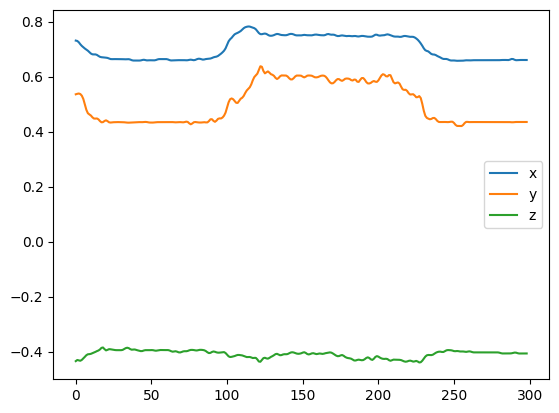

In [58]:
# plot LWrist in all dimensions

import matplotlib.pyplot as plt

plt.plot(mt['LWrist_x'], label='x')
plt.plot(mt['LWrist_y'], label='y')
plt.plot(mt['LWrist_z'], label='z')
plt.legend()
plt.show()


In [60]:
# smoothing with savitzky-golay filter
import scipy

# list possible window
window = [5, 11, 15, 25, 31]
# list possible orders
order = [1, 2, 3]

# col of interest
samplecol = ['LWrist_x', 'LWrist_y', 'LWrist_z']

# iterate over handcols and apply all possible combinations of window and order, save it to new df
# prepare new df
df_smooth = pd.DataFrame()

for col in samplecol:
    for win in window:
        for ord in order:
            df_smooth[col + '_savgol' + str(win) + '_' + str(ord)] = scipy.signal.savgol_filter(mt[col], win, ord)


In [62]:
# make R_Hand_x from df_sample a list
LWrist_x = mt['LWrist_x'].tolist()
LWrist_y = mt['LWrist_y'].tolist()
LWrist_z = mt['LWrist_z'].tolist()


# load these values into df_smooth as a new column
df_smooth['LWrist_x'] = LWrist_x
df_smooth['LWrist_y'] = LWrist_y
df_smooth['LWrist_z'] = LWrist_z

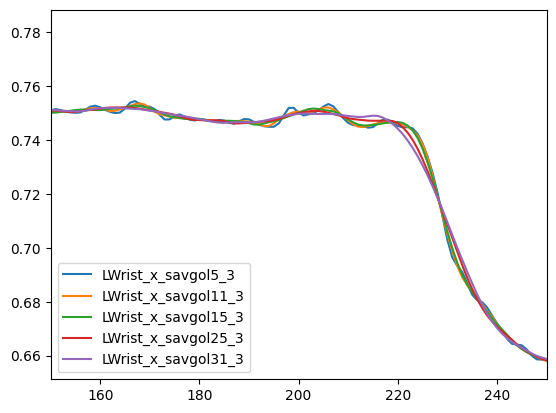

In [70]:
# plot all R_Hand_x columns in one plot

colstoplot = [col for col in df_smooth.columns if 'LWrist_x' in col and '_3' in col]
for col in colstoplot:
    plt.plot(df_smooth[col], label=col)
plt.legend()
# make only timewindow 50 to 250
plt.xlim(150, 250)
plt.show()

## FUNCTIONS

In [2]:
# function to extract env

import numpy as np
import librosa
from scipy.signal import hilbert
from scipy.interpolate import interp1d


# this function mirrors our function from R

def amplitude_envelope_extract(locationsound, smoothing_hz, resampled_hz):
    # read the sound file into Python
    snd, fs = librosa.load(locationsound, sr=None)
    
    # apply the hilbert transform on the signal
    hilb = hilbert(snd)
    
    # apply complex modulus
    env = np.abs(hilb)
    
    # smooth with a hanning window
    window_size = int(fs / smoothing_hz)
    env_smoothed = np.convolve(env, np.hanning(window_size), mode='same') / np.sum(np.hanning(window_size))
    
    # set undeterminable at beginning and end NA's to 0
    env_smoothed = np.nan_to_num(env_smoothed)
    
    # resample settings at desired sampling rate
    time_original = np.linspace(0, len(env_smoothed) / fs, len(env_smoothed))

    # create array for resampled data
    f = interp1d(time_original, env_smoothed, kind='linear', fill_value='extrapolate')
    time_resampled = np.linspace(0, len(env_smoothed) / fs, int(len(env_smoothed) * resampled_hz / fs))
    
    # resample apply
    downsampled = f(time_resampled)
    
    return downsampled

In [3]:
import tempfile
import shutil
import matplotlib.pyplot as plt


# what is the window size in seconds
window = 4

# a function that generates a plot containing two panel time series of the envelope (panel 1) and the pose time series (panel 2) with a window of 4 seconds
def plot_body_signals(body, maxbody, minbody, env, maxenv, minenv, bb, maxbb, minbb, midpoint):
    # make a temporary folder
    tempfolder = tempfile.mkdtemp()
    fig, ax = plt.subplots(3, 1, figsize=(14, 10))
    # selection 4 seconds from midpoint
    start = midpoint - window/2
    end = midpoint + window/2
    # if start is negative, set it to 0
    if start < 0:
        start = 0
    # subset the body time series and amplitude envelope based on the start and end
    body = body[(body['Time'] >= start) & (body['Time'] <= end)]
    env = env[(env['Time'] >= start) & (env['Time'] <= end)]
    bb = bb[(bb['Time'] >= start) & (bb['Time'] <= end)]
    # do a cross correlation between the envelope and the pose time series
    # recenter time
    body['Time'] = body['Time'] - midpoint
    env['Time'] = env['Time'] - midpoint
    bb['Time'] = bb['Time'] - midpoint
    # Plot the amplitude envelope
    ax[0].plot(env['Time'], env['env'], label = 'env', linewidth=8, color='green')
    ax[0].legend() # show labels in legend
    ax[0].legend(prop={'size': 24})
    # Plot the pose time series with a thick line semitransparent, but different colors (black & grey)
    ax[1].plot(body['Time'], body['RWrist_speed'], label='RWrist (speed)', color='magenta', alpha=0.8, linewidth=4)
    ax[1].plot(body['Time'], body['LWrist_speed'], label='LWrist (speed)', color='darkblue', alpha=0.8, linewidth=4)
    ax[1].set_xlabel('Time (s)', fontsize=24)
    ax[1].legend() # show labels in legend
    ax[1].legend(prop={'size': 24})
    plt.tight_layout()
    # plot the bb
    ax[2].plot(bb['Time'], bb['COPc'], label='Center of pressure (change)', color='black', alpha=0.8, linewidth=4)
    ax[2].set_xlabel('Time (s)', fontsize=24)
    ax[2].legend() # show labels in legend
    ax[2].legend(prop={'size': 24})
    plt.tight_layout()
    # set the x axes to centered by 0 minus and plus half the window
    ax[0].set_xlim(-window/2, window/2)
    ax[1].set_xlim(-window/2, window/2)
    ax[2].set_xlim(-window/2, window/2)
    # add a vertical line in the plot at 0
    ax[0].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)
    ax[1].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)
    ax[2].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)

    # ad horizontal lines at 15 for first plot
    #ax[0].axhline(y=15, color='r', linestyle='--', linewidth=4, alpha=0.8)
    # set the y axes 
    # what is the total max and min value in env
    #maxenv = max(env['env'])
    #minenv = min(env['env'])
    ax[0].set_ylim(minenv, maxenv)
    # speed according to max value within both wrists
    #maxbody = max(body['RWrist_speed'].max(), body['LWrist_speed'].max())
    ax[1].set_ylim(minbody, maxbody) #
    # bb according to max value
    #maxbb = max(bb['COPc'].max())
    #minbb = min(bb['COPc'].min())
    ax[2].set_ylim(minbb, maxbb)
    
    # increase font size
    for a in ax:
        a.tick_params(axis='both', which='major', labelsize=24)
        a.tick_params(axis='both', which='major', width=6)
    # save the plot
    tpf = tempfolder + 'tempfig.png'
    plt.savefig(tpf )
    plt.close()
    img = cv2.imread(tpf)
    shutil.rmtree(tempfolder)
    return img

## ANIMATION

From https://www.envisionbox.org/embedded_AnimatingSoundMovement.html


In [4]:

import tqdm
import cv2
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import scipy

resampl_rate = 200
smooth_hz = 8


for folder in foi_mt:
    # if there is a file containing 'animated.mp4' , you can skip this folder
    if len(glob.glob(folder + '/*_animated.mp4')) > 0:
        continue
    print(folder)
    # last element is trialid
    trialid = folder.split('\\')[-1]
    print(trialid)

    ##### PREPARING MT
    csvfiles = glob.glob(folder + '/**/*.csv', recursive=True)
    butterfile = csvfiles[1] # this one is buttered

    # load it
    mt = pd.read_csv(butterfile)

    # show columns
    cols = mt.columns

    # put away 'Time' column from the list ( the last)
    cols = cols[:-1]

    # put away from each colname anything behind _ (including _)
    cols = [x.split('_')[0] for x in cols]

    # keep unique
    colsforspeed = list(set(cols))

    # smooth all columns except time with savgol 15,3
    colstosmooth = mt.columns[:-1]
    mt_smooth = pd.DataFrame()

    for col in colstosmooth:
        mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 3)
        # and put them all to cms
        mt_smooth[col] = mt_smooth[col]*100
        
    # add time column
    mt_smooth['Time'] = mt['Time']

    # what is the sampling rate
    sr = 1/np.mean(np.diff(mt['Time']))

    # for each unique colname (cols), calculate speed from x and y dimensions (_x, _y)
    for col in colsforspeed:
        # get x and y columns
        x = mt_smooth[col + '_x']
        y = mt_smooth[col + '_y']
        z = mt_smooth[col + '_z']
        # calculate speed
        #speed = (x.diff()**2 + y.diff()**2)**0.5
        # add to dataframe
        mt_smooth[col + '_speed'] = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2), 0, 0)
        # multiply the values by sr, because now we have values in m/(s/sr)
        mt_smooth[col + '_speed'] = mt_smooth[col + '_speed']*sr
        
        # smooth with savgol 15, 3
        mt_smooth[col + '_speed'] = savgol_filter(mt_smooth[col + '_speed'], 15, 3)

        # if 'Wrist' in col:
        #     # calculate speed
        #     #speed = (x.diff()**2 + y.diff()**2)**0.5
        #     # add to dataframe
        #     mt_smooth[col + '_vert_vel'] = np.insert(np.diff(z), 0, 0)
        #     # multiply the values by sr, because now we have values in m/(s/sr)
        #     mt_smooth[col + '_vert_vel'] = mt_smooth[col + '_vert_vel']*sr
        #     # absolutize
        #     mt_smooth[col + '_vert_vel'] = np.abs(mt_smooth[col + '_vert_vel'])
        #     # smooth with savgol 15, 3
        #     mt_smooth[col + '_vert_vel'] = scipy.signal.savgol_filter(mt_smooth[col + '_vert_vel'], 15, 3)
    
    # get the max and min values for the speed
    maxbody = max(mt_smooth['RWrist_speed'].max(), mt_smooth['LWrist_speed'].max())
    minbody = 0

    ###### PREPARING AUDIO

    # get audio file from foi_wav with the same trialid
    audiofilename = [x for x in foi_wav if '0_1_trial_35' in x][0]
    ampl_env = amplitude_envelope_extract(audiofilename, smooth_hz, resampl_rate)

    # create time vector
    # create time vector
    env_time = np.arange(0, len(ampl_env) / resampl_rate, 1 / resampl_rate) * 1000

    # create df
    env = pd.DataFrame({'Time': env_time, 'env': ampl_env, 'ID': audiofilename})
    # convert time to seconds
    env['Time'] = env['Time'] / 1000

    print(env)

    # get the max and min values for the envelope
    maxenv = max(env['env'])
    minenv = min(env['env'])

    ###### PREPARING BB

    # get bb file from foi_bb with the same trialid
    bbfilename = [x for x in foi_bb if '0_1_trial_35' in x][0]

    # load it
    bb = pd.read_csv(bbfilename)

    # Rename columns
    bb.columns = ['Time', 'left_back', 'right_forward', 'right_back', 'left_forward']

    # Calculate sampling rate
    bbsamp = 1 / np.mean(np.diff(bb['Time'] - min(bb['Time'])))

    # Apply Savitzky-Golay filter to smooth the data
    for col in bb.columns[1:]:
        bb[col] = savgol_filter(bb[col], 51, 5)

    # Calculate COPX and COPY
    COPX = (bb['right_forward'] + bb['right_back']) - (bb['left_forward'] + bb['left_back'])
    COPY = (bb['right_forward'] + bb['left_forward']) - (bb['left_back'] + bb['right_back'])

    # Calculate COPXc and COPYc
    bb['COPXc'] = savgol_filter(np.insert(np.diff(COPX), 0, 0), 51, 5)
    bb['COPYc'] = savgol_filter(np.insert(np.diff(COPY), 0, 0), 51, 5)

    # Calculate COPc
    bb['COPc'] = np.sqrt(bb['COPXc']**2 + bb['COPYc']**2)

    # add column for filename
    bb['filename'] = bbfilename

    # we need to restart the time in bb, such that it starts from 0
    bb['Time'] = bb['Time'] - min(bb['Time'])

    
    print(bb)

    # get the max and min values for the bb
    maxbb = max(bb['COPc'])
    minbb = min(bb['COPc'])

    # PREPARE VIDEO
    # video files
    videofiles = glob.glob(folder + '/**/*.avi', recursive=True)
    # keep only video1, this is cam2 with openpose
    videofiles = [v for v in videofiles if 'video1' in v]

    # we loop over the video files and generate animated videos (with and without sound)
    for vidf in videofiles:
        print(vidf)
        videofilename = vidf
        #audiofilename = inputfol + vidf.replace(".mp4", ".wav")
        #videofilenamemasked = videofilename.replace(".mp4", "_masked.mp4")
        #print(videofilenamemasked)
        # Get the amplitude envelope
        #ampv, sr = amp_envelope(audiofilename)
        # get the raw audio
        #rawaudio, sr = librosa.load(audiofilename, sr=None)
        # get the mt
        speed = mt_smooth
        # Load the pose time series
        body = mt_smooth
        # load the video in opencv and prepare to loop over it
        capture = cv2.VideoCapture(videofilename)
        frameWidth = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
        frameHeight = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
        fps = capture.get(cv2.CAP_PROP_FPS)
        # out
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        out = cv2.VideoWriter(folder + '/' + trialid + '_sample_wrist_animated.mp4', fourcc, fps, (int(frameWidth)*4, int(frameHeight)))
        # loop over the video
        # loop through the video and add the plot to the video on left upper corner in small inset
        frame_number = 0
        # with progress bar
        for i in tqdm.tqdm(range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))):
            ret, frame = capture.read()
            if ret == True:
                img = plot_body_signals(body, maxbody, minbody, env, maxenv, minenv, bb, maxbb, minbb, frame_number/fps)
                # resize the image
                img = cv2.resize(img, (int(frameWidth*3), int(frameHeight)))
                # lets put the plot on the right side of the frame using concat
                frame = np.concatenate([frame, img], axis=1)            
                out.write(frame)
                frame_number += 1
                # also show the frame (optional)
                #cv2.imshow('Frame', frame)
                #if cv2.waitKey(1) & 0xFF == ord('q'):
                #   break
            else:
                break
        capture.release()
        out.release()    
        cv2.destroyAllWindows()


C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\Session_0_1\P1\0_1_35_p1
0_1_35_p1
       Time           env                                                 ID
0     0.000  5.794370e-07  E:\charade_experiment_WORKSPACE\xdf_procedure\...
1     0.005  7.672499e-07  E:\charade_experiment_WORKSPACE\xdf_procedure\...
2     0.010  9.915581e-07  E:\charade_experiment_WORKSPACE\xdf_procedure\...
3     0.015  1.254133e-06  E:\charade_experiment_WORKSPACE\xdf_procedure\...
4     0.020  1.571941e-06  E:\charade_experiment_WORKSPACE\xdf_procedure\...
...     ...           ...                                                ...
1028  5.140  1.687107e-05  E:\charade_experiment_WORKSPACE\xdf_procedure\...
1029  5.145  1.523200e-05  E:\charade_experiment_WORKSPACE\xdf_procedure\...
1030  5.150  1.350300e-05  E:\charade_experiment_WORKSPACE\xdf_procedure\...
1031  5.155  1.171915e-05  E:\charade_experiment_WORKSPACE\xdf_procedure\...
1032  5.160  9.929604e-06  E:\charade_experiment_WOR

  0%|          | 0/310 [00:00<?, ?it/s]C:\Users\kadava\AppData\Local\Temp\ipykernel_17472\2219107851.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  body['Time'] = body['Time'] - midpoint
C:\Users\kadava\AppData\Local\Temp\ipykernel_17472\2219107851.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env['Time'] = env['Time'] - midpoint
C:\Users\kadava\AppData\Local\Temp\ipykernel_17472\2219107851.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [43]:
import ffmpeg

# add the audio
# load in the video again and add the audio using moviepy
for vidf in videofiles:
    print(vidf)
    # go two folders back in the directory
    #v = vidf.split('\\')[-3] + '/' + vidf.split('\\')[-2] + '/'
    # connect 0-8 element of path vidf
    v = vidf.split('\\')[:8]
    v = '/'.join(v[:4]) + '/'
    # find in v mp4 file with _animated
    animatedfile = glob.glob(v + '*_animated.mp4')[0]
    print(animatedfile)
    audiofilename = [x for x in foi_wav if '0_1_trial_35' in x][0]
    print(audiofilename)
    input_audio = ffmpeg.input(audiofilename)
    print(input_audio)
    print('Loading the video')
    input_video = ffmpeg.input(animatedfile)
    print(input_video)

    print('Combining audio and video')
    output_path = animatedfile.replace('.mp4', '_animated_audio.mp4')
    ffmpeg.concat(input_video, input_audio, v=1, a=1).output(output_path).run(overwrite_output=True)
        
    #save it
    print('Saving the video')

C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata\Session_0_1\P1\0_1_35_p1\pose-2d-trackingvideos\video1.avi
C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata/Session_0_1/P1/0_1_35_p1\0_1_35_p1_sample_wrist_animated.mp4
E:\charade_experiment_WORKSPACE\xdf_procedure\data\Data_processed\Data_trials/Audio_48\0_1_trial_35_Mic_nominal_srate48000_p1_langzaam_combinatie.wav
input(filename='E:\\charade_experiment_WORKSPACE\\xdf_procedure\\data\\Data_processed\\Data_trials/Audio_48\\0_1_trial_35_Mic_nominal_srate48000_p1_langzaam_combinatie.wav')[None] <1de3190524b5>
Loading the video
input(filename='C:/Users/kadava/Documents/Github/FLESH_3Dtracking_new/projectdata/Session_0_1/P1/0_1_35_p1\\0_1_35_p1_sample_wrist_animated.mp4')[None] <c1358c19e5aa>
Combining audio and video
Saving the video
